<a href="https://colab.research.google.com/github/mjee12/lungDisease/blob/master/lungDisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Purpose: Look at chest x-ray data and classify whether the patient is healthy, has Covid-19, or other viral/bacterial viruses



In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
#tensorflow for deep learning, keras for building and training advanced DL models
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
xray_train_dir = '/content/drive/My Drive/Covid-19 Project/Dataset'

In [ ]:
os.listdir(xray_train_dir)

['1', '2', '3', '0']

Each number above represents the four different classes: Healthy, Covid-19, Bacterial Pneumonia, and Viral Pneumonia

In [ ]:
#divide training data into 80% train and 20% cross validation dataset (prevent the model from overfitting)
#use an image generator to normalize data by generating tensor images data
imageGenerator = ImageDataGenerator(rescale= 1./255, validation_split= .2)

In [ ]:
#need to generate training batches of images
#batches of size 40
#make sure the order is shuffled so the model does not just learn the order of the images
#perform resizing
trainGenerator = imageGenerator.flow_from_directory(batch_size = 40, directory = xray_train_dir, shuffle = True, 
                                                     target_size = (256, 256), class_mode = 'categorical', subset = 'training')

Found 428 images belonging to 4 classes.


In [ ]:
validationGenerator = imageGenerator.flow_from_directory(batch_size = 40, directory = xray_train_dir, shuffle = True, 
                                                     target_size = (256, 256), class_mode = 'categorical', subset = 'validation')

Found 104 images belonging to 4 classes.


428 and 104 are correct numbers because there are 133 images in each class, which leads to 532 images, and 428 + 104 = 532.

In [ ]:
trainImg, trainLab = next(trainGenerator)

In [ ]:
trainLab
#where the 1 represents the label

array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.]],

In [ ]:
names = {0: 'Covid-19', 1: 'Normal', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia'}

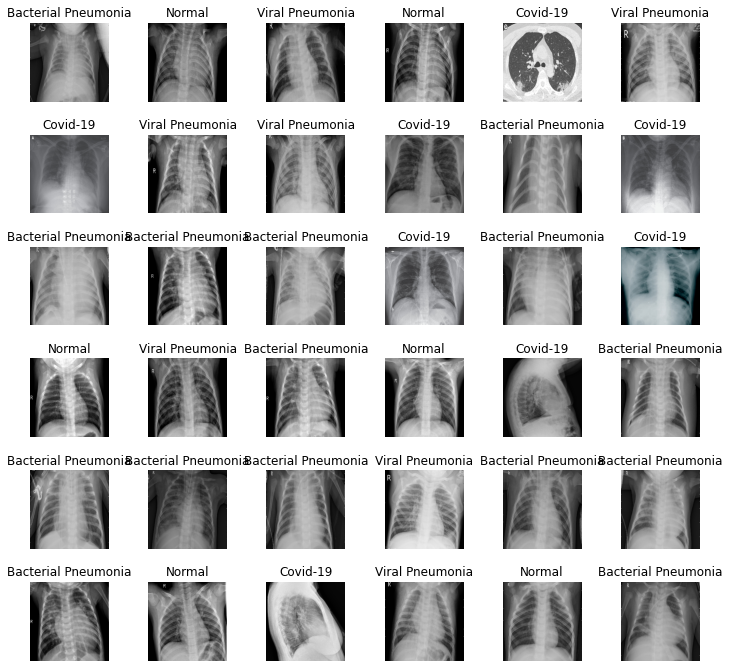

In [ ]:
#visualization of data
l = 6
w = 6

fig, axes = plt.subplots(l, w, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, l*w):
  axes[i].imshow(trainImg[i])
  label = np.argmax(trainLab[i])
  axes[i].set_title(names[label])
  axes[i].axis('off')

plt.subplots_adjust(wspace = .5)

Method: Convolutional Neural Network

I will be using ResNet, which has error of 3.57%, a far superior error rate than that of humans




1. Import Model with pretrained weights (Transfer Learning)

In [ ]:
base = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape= (256, 256, 3)))
#using 'imagenet' which consists of millions of images so the model should already be familiar with a huge variety of images

94773248/94765736 [==============================] - 1s 0us/step


In [ ]:
base.summary()

In [ ]:
#freeze the top layers and keep the last 10 to be trainable
for layer in base.layers[:-10]:
  layers.trainable = False

2. Build and train deep learning model

In [ ]:
#start building on top of the base model defined above
#head = classification model
head = base.output
#add average pooling layer
head = AveragePooling2D(pool_size= (4,4))(head)
#add flatten layer
head = Flatten(name = 'flat')(head)
#add dense fully connected artificial neural network with 256 neurons and 'relu' activation function
head = Dense(256, activation= 'relu')(head)
#add drop layer that drops 30% of the neurons to avoid overfitting and for the model to generalize, not memorize
head = Dropout(.3)(head)
#repeat dense + dropout
head = Dense(128, activation= 'relu')(head)
head = Dropout(.2)(head)
#final dense layer with 4 outputs for the 4 possible classes
#no longer 'relu' activation because the output is not continuous but either 1 or 0
head = Dense(4, activation= 'softmax')(head)

In [ ]:
model = Model(inputs = base.input, outputs = head)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer= optimizers.RMSprop(lr = 1e-4), metrics= ['accuracy'])

In [ ]:
#stop early if validation loss is not decreasing after a certain number (20) of epochs
stop = EarlyStopping(monitor = 'val_loss', mode= 'min', patience= 20)
#save the best model with lower validation loss
checkpt = ModelCheckpoint(filepath = 'bestModel', verbose = 1, save_best_only= True)

In [ ]:
trainGenerator = imageGenerator.flow_from_directory(batch_size= 4, directory= xray_train_dir,
                                                    shuffle = True, target_size = (256, 256),
                                                    class_mode = 'categorical', subset = 'training')
validationGenerator = imageGenerator.flow_from_directory(batch_size= 4, directory= xray_train_dir,
                                                    shuffle = True, target_size = (256, 256),
                                                    class_mode = 'categorical', subset = 'validation')

Found 428 images belonging to 4 classes.
Found 104 images belonging to 4 classes.


In [ ]:
history = model.fit_generator(trainGenerator, epochs = 10, validation_data= validationGenerator, callbacks = [checkpt, stop])

Accuracy seems pretty high but the validation accuracy could be better. 

In [ ]:
head2 = base.output
head2 = AveragePooling2D(pool_size= (4,4))(head2)
head2 = Flatten(name = 'flat')(head2)
head2 = Dense(256, activation= 'relu')(head2)
head2 = Dropout(.3)(head2)
head2 = Dense(256, activation= 'relu')(head2)
head2 = Dropout(.3)(head2)
head2 = Dense(4, activation= 'softmax')(head2)

In [ ]:
model2 = Model(inputs = base.input, outputs = head2)

In [ ]:
model2.compile(loss = 'categorical_crossentropy', optimizer= optimizers.RMSprop(lr = 1e-4), metrics= ['accuracy'])

In [ ]:
history = model2.fit_generator(trainGenerator, epochs = 25, validation_data= validationGenerator, callbacks = [checkpt, stop])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
107/107 [==============================] - ETA: 0s - loss: 0.8730 - accuracy: 0.7266
Epoch 00001: val_loss improved from inf to 14.56818, saving model to bestModel
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: bestModel/assets
107/107 [==============================] - 486s 5s/step - loss: 0.8730 - accuracy: 0.7266 - val_loss: 14.5682 - val_accuracy: 0.2500
Epoch 2/25
107/107 [==============================] - ETA: 0s - loss: 0.4260 - accuracy: 0.8785
Epoch 00002: val_loss did not improve from 14.56818
107/107 [==============================] - 404s 4s/step - loss: 0.4260 - accuracy: 0.8785 - val_loss: 26.1023 - val_accuracy: 0.2500
Epoch 3/25
107/107 [=============================

Much higher accuracy and validation accuracy

3. Evaluate trained model

Text(0.5, 0, 'Num of Epochs')

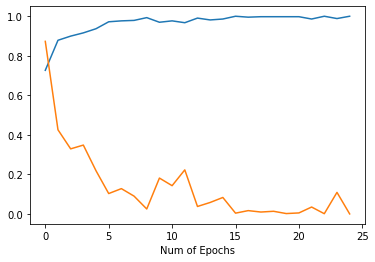

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel('Num of Epochs')

Text(0.5, 0, 'Num of Epochs')

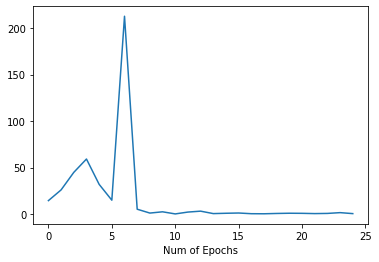

In [ ]:
plt.plot(history.history['val_loss'])
plt.xlabel('Num of Epochs')

Text(0.5, 0, 'Num of Epochs')

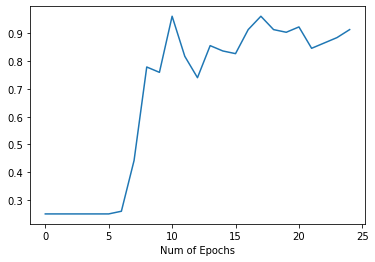

In [ ]:
plt.plot(history.history['val_accuracy'])
plt.xlabel('Num of Epochs')

In [ ]:
xray_test_dir = '/content/drive/My Drive/Covid-19 Project/Test'

In [ ]:
generator = ImageDataGenerator(rescale = 1./255)
testGenerator = generator.flow_from_directory(batch_size = 40, directory = xray_test_dir, 
                                              shuffle = True, target_size = (256, 256), class_mode = 'categorical')

Found 40 images belonging to 4 classes.


In [ ]:
evaluate = model2.evaluate_generator(testGenerator, steps = testGenerator.n // 4, verbose = 1)
print(evaluate[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
 1/10 [==>...........................] - 0s 75ms/step - loss: 2.5295 - accuracy: 0.7750
0.7749999761581421


Accuracy is pretty high considering the model has never seen the test dataset

4. Find the accuracy of the model for the test dataset

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

imageList = []
predicted = []
expected = []

for i in range(len(os.listdir(xray_test_dir))):
  for j in os.listdir(os.path.join(xray_test_dir, str(i))):
    image = cv2.imread(os.path.join(xray_test_dir, str(i), j))
    image = cv2.resize(image, (256, 256))
    imageList.append(image)
    image = image / 255
    image = image.reshape(-1, 256, 256, 3)
    pred = model2.predict(image)
    pred = np.argmax(pred)
    predicted.append(pred)
    expected.append(i)

In [ ]:
acc = accuracy_score(expected,predicted)
print("Accuracy of Test Dataset : {}".format(acc))

Accuracy of Test Dataset : 0.725


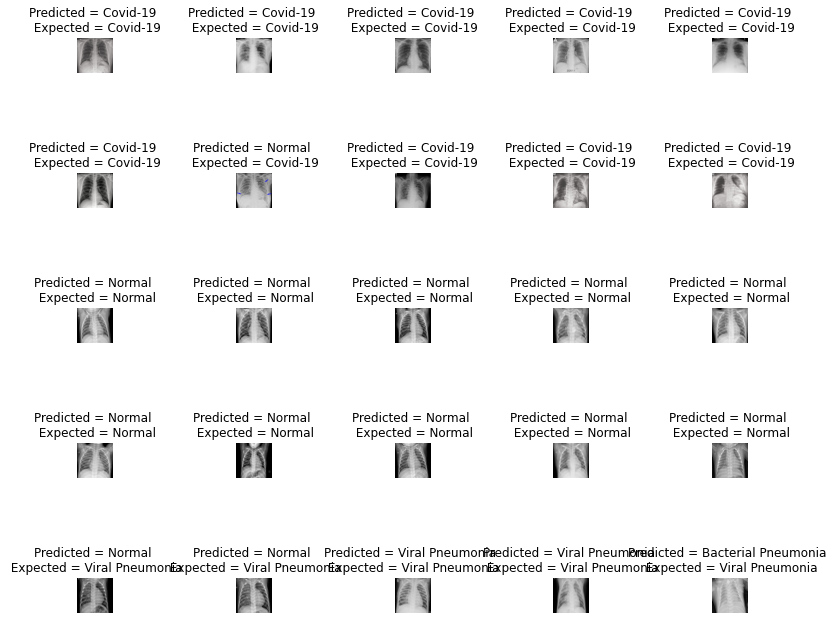

In [ ]:
l = 5
w = 5

fig, axes = plt.subplots(l, w, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, l*w):
  axes[i].imshow(imageList[i])
  pred = names[predicted[i]]
  expt = names[expected[i]]
  axes[i].set_title("Predicted = {} \n Expected = {}".format(str(pred), str(expt)))
  axes[i].axis('off')

plt.subplots_adjust(wspace = 3.5)

In [ ]:
print(classification_report(np.asarray(expected), np.asarray(predicted)))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       0.62      1.00      0.77        10
           2       0.62      0.50      0.56        10
           3       0.71      0.50      0.59        10

    accuracy                           0.73        40
   macro avg       0.74      0.72      0.72        40
weighted avg       0.74      0.72      0.72        40

